In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pwd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import IPython.display as ipd

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import librosa
from librosa.display import specshow
from librosa.display import waveshow
from librosa.feature import melspectrogram
from librosa.feature import mfcc

###### Exploratory analysis

###### Case study

In [7]:
"""
Wave & features
"""
def _padd(wav, sr):
    if wav.shape[0] < 5*sr:
        wav=np.pad(wav, int(np.ceil((5*sr - wav.shape[0])/2)), mode='reflect')
    else:
        wav=wav[:5*sr]
    return wav


def _continuous2discrete(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


def get_wave(path, sr=None):
    wav, sr = librosa.load(path, sr=sr)
    return wav, sr


def get_feature(wav,
                add_padding=True,
                add_db=True,
#                 discrete=True,
                discrete=False,
                feature=melspectrogram,
                  sr=None,
                  n_fft=2048, 
                  hop_length=512, 
                  n_mels=128, 
                  fmin=20, 
                  fmax=8300, 
                  top_db=80,
                   eps=1e-6):
    
    if add_padding:
        wav = _padd(wav, sr)
    
    spec = feature(wav, 
                  sr=sr,
                  n_fft=n_fft,
                  hop_length=hop_length,
                  n_mels=n_mels,
                  fmin=fmin,
                  fmax=fmax)

    if add_db:
        spec = librosa.power_to_db(spec, top_db=top_db)
    
    if discrete:
        spec = _continuous2discrete(spec, eps=eps)
    
    return spec



"""
Plot
"""
def plot_audio(path):
    return ipd.Audio(path)


def plot_wave(wav, title="wave"):
    waveshow(wav, x_axis='time')
    plt.title(title)
    plt.show()
    
    
def plot_feature(feature, title="melspectrogram"):
    specshow(feature, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)
    plt.show()
    

    
"""
Case study
"""
def audio_info(path, 
               sr=None, 
               features_dct={"melspectrogram": melspectrogram,
                             "mfcc": mfcc}):

    wav, sr = librosa.load(path, sr=sr)
    plot_wave(wav)
    for name, feature in features_dct.items():
        f = get_feature(wav, sr=sr, feature=feature)
        plot_feature(f, title=name)
    return plot_audio(path)

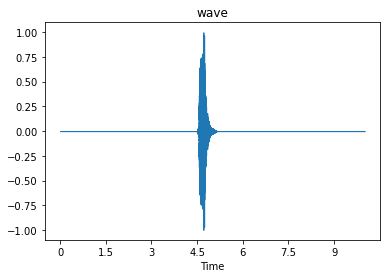

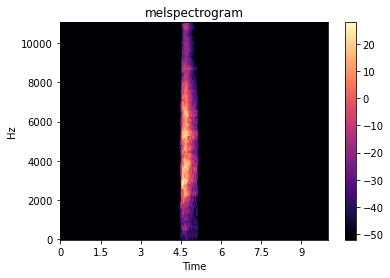

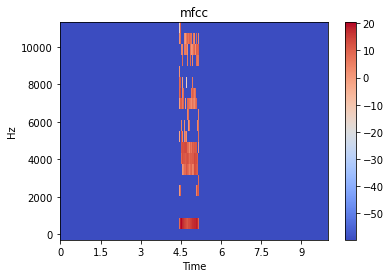

In [9]:
# audio_info('drive/MyDrive/DEEPSOUND/ESC-50-master/audio/1-100032-A-0.wav')
audio_info('../ESC-50-master/audio/1-100032-A-0.wav')

###### Construct Datasets

In [71]:
def cross_validation_dataset(df):
    pairs = []
    folds = df.fold.unique()
    for fold in folds:
        train_df = df[df.fold != fold]
        test_df = df[df.fold == fold]
    pairs.append((train_df, test_df))
    return pairs

In [76]:
"""
DF
"""
def get_target_description(df):
    return df[["target", "category"]].groupby("target").first()


def get_target_distribution(df, title="distribution_of_targets", ax=None, show=False):
    ax = df.target.hist(bins=50, alpha=0.5, edgecolor="black", ax=ax)
    ax.set_xlabel("target")
    ax.set_ylabel("number_of_data_points")
    if show:
        plt.title(title)
        plt.show()
    else:
        return ax
    
    
def get_folds(df):
    fold_dct = dict()
    for fold in df.fold.unique():
        fold_dct[fold] = df[df.fold == fold]
    return fold_dct


def folds_info(dct):
    print(f"Number_of_folds: {len(dct)}")
    print()
    for i, fold in dct.items():
        print(f"fold: {i} | size: {fold.shape[0]}")
    print()
    
    
def get_fold_distribution(dct):
    print("Distribution of targets across folds:")
    fig, axs = plt.subplots(nrows=1, ncols=len(dct), figsize=(20, 2))
    for i, fold in dct.items():
        _ax = axs[i - 1]
        get_target_distribution(fold, ax=_ax)
        _ax.set_title(f"fold_{i}")
    plt.show()         
        
        
def get_df(path, only_esc10=True):
    df = pd.read_csv(path)
    if only_esc10:
        df = df[df.esc10 == True]
    return df
        

def extract_data(path, only_esc10=True):
    
    if only_esc10:
        print(f"Use only 10 classes!")
        print()
        
    df = get_df(path, only_esc10=only_esc10)
    
    folds = get_folds(df)
    folds_info(folds)
    get_fold_distribution(folds)
    
    info_df = get_target_description(df)    
        
    return info_df, df


def train_test_split(df, test_fold=1):
    train_df = df[df.fold != test_fold]
    test_df = df[df.fold == test_fold]
    return train_df, test_df



"""
Dataset
"""
class ESC50Data(Dataset):
    
    def __init__(self, 
                 df,
                 feature=melspectrogram,
                 base_dir='../ESC-50-master/audio', 
                 in_col='filename', 
                 out_col='category'):
                ### add args
        
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())

        for i, category in enumerate(self.categories):
            self.c2i[category] = i
            self.i2c[i] = category
            
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base_dir, row[in_col])
            self.labels.append(self.c2i[row[out_col]])
            
            wav, sr = get_wave(file_path)
            point_feature = get_feature(wav, sr=sr, feature=feature)
            self.data.append(point_feature[np.newaxis,...])
            
            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    

    
"""
Loaders
"""
def get_train_test_loaders(df,
                            base_dir='../ESC-50-master/audio',
                            feature=melspectrogram,
                            test_fold=None, 
                            batch_size=16,
                            shuffle=True):
    
    train_df, test_df = train_test_split(df, test_fold=test_fold)
    
    print("Construct loaders...")
    
    print("train_data:")
    train_data = ESC50Data(train_df, base_dir=base_dir, feature=feature)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    
    print("test_data:")
    test_data = ESC50Data(test_df, base_dir=base_dir, feature=feature)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle) ### !!!
    
    return train_loader, test_loader


def get_cross_validation_loaders(df,
                                 base_dir='../ESC-50-master/audio',
                                    feature=melspectrogram, 
                                    batch_size=16,
                                    shuffle=True):
    
    loaders = []
    folds = df.fold.unique()
    for fold in tqdm(folds, desc="FOLDS"):    
        train_loader, test_loader = get_train_test_loaders(df,
                                                            base_dir=base_dir,
                                                            feature=feature,
                                                            test_fold=fold, 
                                                            batch_size=batch_size,
                                                            shuffle=shuffle)
        loaders.append((train_loader, test_loader))
        
    return loaders       


def get_loaders_from_csv(csv_path, # ?
                         base_dir='../ESC-50-master/audio',
                         only_esc10=True, 
                         test_fold=1, 
                         batch_size=16, 
                         shuffle=True, 
                         feature=melspectrogram):
    
    
    info_df, df = extract_data(csv_path, only_esc10=only_esc10)
    print("targets:")
    print(info_df)
    print()
    train_loader, test_loader = get_loaders(df,
                                            base_dir=base_dir,
                                            feature=feature,
                                            test_fold=test_fold, 
                                            batch_size=batch_size,
                                            shuffle=shuffle)
    
    return train_loader, test_loader


def get_cross_validation_loaders_from_csv(csv_path):
    pass ### TO DO

Use only 10 classes!

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


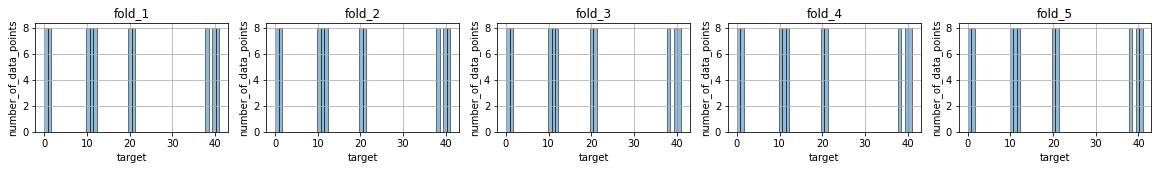

targets:
              category
target                
0                  dog
1              rooster
10                rain
11           sea_waves
12      crackling_fire
20         crying_baby
21            sneezing
38          clock_tick
40          helicopter
41            chainsaw

Construct loaders...
train_data:


100%|█████████████████████████████████████████| 320/320 [00:07<00:00, 40.85it/s]


test_data:


100%|███████████████████████████████████████████| 80/80 [00:01<00:00, 41.81it/s]


In [12]:
# csv_path = "drive/MyDrive/DEEPSOUND/ESC-50-master/meta/esc50.csv"
# base_dir = "drive/MyDrive/DEEPSOUND/ESC-50-master/audio"

csv_path = "../ESC-50-master/meta/esc50.csv"
base_dir = "../ESC-50-master/audio"


train_loader, test_loader = get_loaders_from_csv(csv_path, base_dir=base_dir)

###### MODEL

In [39]:
import torch
import torch.nn as nn
# import torch.optim as optim

from torch.optim import Adam


from torchvision.models import resnet34

In [79]:
"""
Dummy model
"""
class Model(nn.Module):
    def __init__(self, in_dim=1*128*431, out_dim=50):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, out_dim))
        
    def forward(self, xb):
        x = xb.flatten(start_dim=1)
        return self.network(x)


"""
Funcs
"""
def get_device():
    return torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


def _init_model(in_dim=1*128*431, out_dim=50):
    model = Model(in_dim=in_dim, out_dim=out_dim)
#     model = resnet34(pretrained=True)
#     model.fc = nn.Linear(512, 50)
#     model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = model.to(device)
    return model


def lr_decay(optimizer, epoch):
#     if epoch%10==0:
    if epoch%2==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer.param_groups[0]['lr'] = new_lr
        print(f'Changed learning rate to {new_lr}')
    return optimizer


def train(model, 
          train_loader, 
          valid_loader,
          optimizer,
          epochs=50,
          loss_fn=nn.CrossEntropyLoss(),
          change_lr=None):
      
    train_losses = []
    valid_losses = []    
    accuracies = []
    
    for epoch in tqdm(range(1, epochs + 1)):
        
        # 1. train
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
            
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
            
#             print(f"y: {y}")            
#             print(f"y_hat: {y_hat}")
            
        train_loss = np.mean(batch_losses)    
        train_losses.append(train_loss)
        print(f'Epoch: {epoch} | Train_Loss : {train_loss}')
        
        
        # 2. validate
        if valid_loader is not None:
            model.eval()
            batch_losses=[]
            trace_y = []
            trace_y_hat = []

            for i, data in enumerate(valid_loader):
                x, y = data
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.long)

                y_hat = model(x)
                loss = loss_fn(y_hat, y)
                trace_y.append(y.cpu().detach().numpy())
                trace_y_hat.append(y_hat.cpu().detach().numpy())      
                batch_losses.append(loss.item())

            valid_loss = np.mean(batch_losses[-1])    
            valid_losses.append(valid_loss)

            trace_y = np.concatenate(trace_y)
            trace_y_hat = np.concatenate(trace_y_hat)

            accuracy = np.mean(trace_y_hat.argmax(axis=1) == trace_y) ## ???
            accuracies.append(accuracy)

            print(f"Epoch: {epoch} | Valid_Loss : {valid_loss}") 
            print(f"Valid_Accuracy : {accuracy}")
    
    return model, optimizer, train_losses, valid_losses

    
def plot_losses(train_losses, valid_losses):
    assert len(train_losses) == len(valid_losses)
    epochs = len(train_losses)
    x = np.linspace(1, epochs, epochs) 
    plt.plot(x, train_losses, label="train_loss")
    plt.plot(x, valid_losses, label="validation_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Training process")
    plt.legend()
    plt.show()
    
    
    
"""
Main class
"""
class AudioClassifier:
    
    # add loader with full data
    
    def __init__(self, data_path, feature=melspectrogram, batch_size=16, shuffle=True):
        self.full_loader = get_full_loader_from_csv(data_path,
                                                      feature=feature,
                                                      batch_size=batch_size,
                                                      shuffle=shuffle)
        
        self.cross_validation_loaders = get_cross_validation_loaders_from_csv(data_path,
                                                                              feature=feature,
                                                                              batch_size=batch_size,
                                                                              shuffle=shuffle)
           
    def _fit(self, 
            train_loader, 
            test_loader, 
            epochs=50, 
            optim=Adam, 
            lr=2e-4, 
            loss_fn=nn.CrossEntropyLoss(), 
            change_lr=lr_decay,
            plot_training=True):
        
        model = _init_model()
        optimizer = optim(model.parameters(), lr=lr)
        model, optimizer, train_losses, test_losses = train(model,  
                                                              train_loader, 
                                                              test_loader, 
                                                              optimizer,
                                                              epochs=epochs, 
                                                              change_lr=change_lr)
        
        self.model = model
        self.optimizer = optimizer
        self.train_losses = train_losses
        self.test_losses = test_losses
        if plot_training:
            plot_losses(train_losses, test_losses)       
    
       
    def cross_validation(self, plot_training=True):
        cross_val_scores = []
        for train_loader, test_loader in tqdm(self.cross_validation_loaders, 
                                              desc="CROSS_VALIDATION"):
            
            self._fit(train_loader, 
                      test_loader, 
                      plot_training=plot_training)
            
            score = self.test_losses[-1]
            cross_val_scores.append(score)

        self.cross_val_scores = cross_val_scores
        self.mean_score = np.mean(cross_val_scores)
        print(f"--- CROSS VALIDATION SCORE: {self.mean_score} ---")
        
    
    def full_data_fit(self):
        pass
        
        
        
    def predict(self, loader):
        return self.model(loader)
    

  0%|                                                     | 0/5 [00:00<?, ?it/s]

y: tensor([7, 9, 8, 1, 3, 3, 2, 9, 7, 1, 7, 9, 0, 6, 0, 0])
y_hat: tensor([[ 5.2970e+01, -2.0011e+01, -1.1316e+00, -5.6897e+00,  3.8591e+01,
          2.4013e+01, -3.6932e+01,  2.8313e+01,  3.6380e+01, -1.8388e+01,
          2.5516e+01, -6.0268e+00, -5.2302e+01, -1.3443e+01,  1.0390e+01,
         -1.5524e+01,  3.5316e+01,  3.1758e+01,  5.1758e+01, -1.3138e+01,
         -3.1694e+01, -1.0871e+01, -2.9126e+01, -1.3407e+00, -1.3914e+01,
         -3.6135e+00, -6.4352e+00, -1.6518e+01, -9.1969e+00,  4.3168e+01,
         -3.8804e+01, -2.6815e+01,  1.5302e+01,  1.5779e+01,  2.3318e+01,
          5.9694e+00,  2.0897e+01,  5.1745e+01,  4.4352e+01, -9.2443e+00,
          3.7772e+01,  1.3114e+01,  1.8668e+00,  1.3570e+01, -2.7940e+01,
         -1.6696e+00, -4.1931e+00, -1.7297e+01,  7.2551e-01, -1.0170e+01],
        [ 3.4571e+01, -1.5533e+01, -1.3617e+01,  1.5149e+00,  4.3825e+01,
          4.1492e+01, -3.0097e+01,  2.6990e+01,  1.7834e+01, -9.9345e+00,
          9.0912e+00, -1.0159e+01, -6.2094e+

y: tensor([4, 0, 0, 3, 2, 2, 4, 8, 9, 9, 4, 2, 9, 7, 2, 5])
y_hat: tensor([[-1.9073e+02,  1.7849e+02,  1.3941e+02,  2.6561e+02,  1.2216e+02,
          1.3635e+01,  1.8919e+02,  8.1963e+01,  1.8526e+02,  2.5142e+02,
         -9.9587e+01, -1.4520e+02, -7.5281e+01, -1.2034e+02, -1.3743e+02,
         -8.3537e+01, -2.2350e+02, -2.3595e+02, -2.0404e+02, -1.3445e+02,
         -1.4155e+02, -1.0972e+02, -1.3777e+02, -2.3345e+02, -3.0060e+01,
         -1.0627e+02, -9.5330e+01, -1.1427e+02, -1.2073e+02, -1.9586e+02,
         -1.5377e+02, -9.8517e+01, -1.3172e+02, -1.1170e+02, -1.4227e+02,
         -9.2934e+01, -1.4460e+02, -2.2434e+02, -1.7709e+02, -1.3435e+02,
         -2.3187e+02, -1.2602e+02, -1.2537e+02, -1.2531e+02, -9.7032e+01,
         -1.3150e+02, -1.0495e+02, -1.1160e+02, -1.0836e+02, -5.7800e+01],
        [-4.4635e+02,  4.0282e+02,  3.3122e+02,  5.1845e+02,  2.2029e+02,
          8.2011e+01,  4.1114e+02,  1.3631e+02,  3.5794e+02,  4.8341e+02,
         -2.1891e+02, -1.8457e+02, -1.9683e+

y: tensor([7, 4, 4, 5, 4, 2, 6, 7, 3, 8, 3, 5, 4, 8, 3, 9])
y_hat: tensor([[-1.0287e+03,  7.5049e+02,  1.0001e+03,  4.3048e+02,  1.2295e+03,
          7.6286e+02,  9.9436e+02,  5.0468e+02,  7.0972e+02,  1.1783e+03,
         -5.3148e+02, -3.9835e+02, -3.0799e+02, -3.9293e+02, -5.2853e+02,
         -2.1550e+02, -1.2615e+03, -1.2067e+03, -1.2827e+03, -5.1177e+02,
         -3.8702e+02, -4.4909e+02, -5.2672e+02, -1.2010e+03, -8.7600e+01,
         -3.5715e+02, -3.4912e+02, -3.2724e+02, -5.0872e+02, -1.1601e+03,
         -3.9591e+02, -2.8111e+02, -5.2599e+02, -5.0645e+02, -3.7281e+02,
         -3.4039e+02, -4.0021e+02, -1.2711e+03, -9.9194e+02, -5.1803e+02,
         -1.2488e+03, -3.5218e+02, -4.9730e+02, -5.1749e+02, -3.6290e+02,
         -5.3136e+02, -3.6471e+02, -5.1024e+02, -3.8544e+02, -1.1072e+02],
        [-1.1142e+03,  7.8882e+02,  1.0111e+03,  4.1648e+02,  1.3119e+03,
          7.3607e+02,  1.0077e+03,  4.3971e+02,  6.8974e+02,  1.2282e+03,
         -4.6598e+02, -3.3129e+02, -2.7482e+

y: tensor([0, 6, 9, 7, 1, 4, 4, 6, 1, 0, 1, 1, 7, 9, 5, 8])
y_hat: tensor([[ 1.2804e+01,  2.1278e+01,  6.6547e+00,  8.1298e-01,  1.3093e+01,
          5.5016e+01,  2.5171e+01, -2.5722e+01,  7.4390e+01, -2.1779e+00,
         -3.2525e+01, -9.6842e+01, -7.9096e+01, -1.2163e+02, -3.6297e+01,
         -8.2008e+01, -3.9351e+01, -1.3107e+01, -1.9141e+01, -7.2613e+01,
         -1.0249e+02, -4.9721e+01, -4.3191e+01, -2.3506e+01, -2.9112e+01,
         -1.1399e+02, -1.1731e+02, -1.0517e+02, -5.4977e+01, -3.6315e+01,
         -1.0152e+02, -5.7850e+01, -3.9543e+01, -4.3071e+01, -1.1078e+02,
         -1.0682e+02, -9.6735e+01, -3.1467e+01, -5.2757e+01, -6.0459e+01,
         -2.7222e+01, -1.1034e+02, -7.4893e+01, -3.5640e+01, -1.1035e+02,
         -5.2489e+01, -1.1623e+02, -5.8461e+01, -9.2064e+01, -4.4755e+01],
        [-2.2184e+02,  2.4548e+02,  2.8679e+02,  9.1425e+01,  2.0609e+02,
          2.6507e+02,  2.2855e+02,  1.8823e+02,  1.9486e+02,  2.5714e+02,
         -1.6726e+02, -1.0390e+02, -1.3536e+

y: tensor([7, 3, 5, 6, 7, 8, 7, 5, 1, 0, 8, 0, 7, 9, 6, 5])
y_hat: tensor([[-8.9128e+02,  1.1451e+03,  1.0825e+03,  6.0049e+02,  1.1071e+03,
          4.1120e+02,  5.7874e+02,  1.5617e+03,  9.6261e+02,  6.3741e+02,
         -6.4105e+02, -4.8600e+02, -2.9348e+02, -4.3113e+02, -6.3476e+02,
         -2.2485e+02, -1.6176e+03, -1.4906e+03, -1.6614e+03, -6.1451e+02,
         -4.7848e+02, -5.0488e+02, -6.1547e+02, -1.5704e+03, -8.5702e+01,
         -4.0600e+02, -3.8327e+02, -3.4343e+02, -6.1638e+02, -1.5202e+03,
         -4.9054e+02, -2.7012e+02, -6.4313e+02, -6.1944e+02, -4.5951e+02,
         -3.8606e+02, -4.9328e+02, -1.6079e+03, -1.2348e+03, -6.1403e+02,
         -1.6429e+03, -4.3084e+02, -5.9283e+02, -6.2718e+02, -4.1401e+02,
         -6.6209e+02, -4.0209e+02, -5.9918e+02, -4.0567e+02, -1.0019e+02],
        [-6.6202e+02,  9.2879e+02,  9.3991e+02,  4.9553e+02,  8.8029e+02,
          4.3635e+02,  4.8595e+02,  1.1256e+03,  7.8038e+02,  5.3223e+02,
         -5.2973e+02, -4.2577e+02, -2.9412e+

 20%|█████████                                    | 1/5 [00:01<00:05,  1.30s/it]

y_hat: tensor([[-6.1139e+02,  1.2885e+03,  1.1708e+03,  8.7242e+02,  1.3486e+03,
          7.5781e+02,  5.2326e+02,  1.1274e+03,  7.9686e+02,  5.1222e+02,
         -6.4127e+02, -5.3642e+02, -3.5985e+02, -5.5098e+02, -6.4580e+02,
         -2.8173e+02, -1.7380e+03, -1.6341e+03, -1.8126e+03, -6.4555e+02,
         -5.3855e+02, -5.2500e+02, -6.0391e+02, -1.6015e+03, -7.8319e+01,
         -5.5515e+02, -5.1536e+02, -4.4877e+02, -6.6015e+02, -1.5811e+03,
         -5.4625e+02, -3.2395e+02, -6.4620e+02, -6.6369e+02, -5.2189e+02,
         -5.1913e+02, -5.5056e+02, -1.7790e+03, -1.3885e+03, -6.5267e+02,
         -1.7653e+03, -5.1180e+02, -6.4741e+02, -6.3543e+02, -5.1268e+02,
         -6.6592e+02, -5.4306e+02, -6.3350e+02, -5.1681e+02, -1.3215e+02],
        [-6.1912e+02,  9.8109e+02,  1.0810e+03,  7.5780e+02,  1.0618e+03,
          4.6278e+02,  4.6154e+02,  1.4006e+03,  7.3415e+02,  5.0450e+02,
         -7.5540e+02, -4.7510e+02, -2.8505e+02, -4.1670e+02, -7.5737e+02,
         -1.9430e+02, -1.5640e

y: tensor([6, 0, 8, 6, 7, 8, 9, 3, 2, 6, 2, 8, 9, 9, 7, 1])
y_hat: tensor([[-1.5724e+02,  2.0089e+02,  1.2437e+02,  2.2144e+02,  2.1850e+02,
          8.0358e+01,  7.1321e+01,  1.9980e+02,  2.4597e+02,  1.1835e+02,
         -1.0072e+02, -3.9966e+01,  2.1058e+00, -7.9052e+00, -1.0032e+02,
          1.7941e+01, -3.1243e+02, -2.6112e+02, -3.2983e+02, -4.6291e+01,
         -4.2747e+01, -5.6918e+01, -9.8761e+01, -2.8297e+02,  6.2351e+00,
          2.4115e+00,  4.8969e-01, -3.3863e+00, -6.6743e+01, -2.9165e+02,
         -4.1217e+01, -2.4414e+00, -9.4151e+01, -9.4937e+01, -3.5839e+01,
         -7.2289e-02, -3.8415e+01, -3.1082e+02, -1.3045e+02, -7.8219e+01,
         -3.1844e+02, -1.9509e+01, -5.0666e+01, -8.9481e+01, -5.7384e-01,
         -8.1153e+01,  4.9905e+00, -6.7854e+01, -1.5117e+00,  1.1888e+01],
        [ 2.3909e+02, -5.7446e+01, -9.0560e+01, -8.5267e+00, -6.8810e+01,
          3.6501e+01,  1.7663e+01, -2.7217e+01,  1.9047e+01, -7.2970e+01,
         -1.0801e+02, -1.3374e+02, -8.9667e+

y: tensor([7, 0, 8, 0, 3, 9, 4, 0, 0, 4, 7, 9, 0, 0, 8, 8])
y_hat: tensor([[-6.2066e+01,  9.4641e+02,  9.7736e+02,  1.0044e+03,  8.5815e+02,
          9.8772e+02,  5.2923e+02,  6.5488e+02,  9.1146e+02,  6.2959e+02,
         -6.5856e+02, -5.6649e+02, -4.8128e+02, -7.1312e+02, -6.8388e+02,
         -4.0639e+02, -1.6256e+03, -1.4791e+03, -1.7161e+03, -7.4178e+02,
         -5.8803e+02, -5.5323e+02, -6.4942e+02, -1.4675e+03, -1.0174e+02,
         -7.4644e+02, -7.2975e+02, -5.6854e+02, -7.4442e+02, -1.6632e+03,
         -5.7457e+02, -3.8801e+02, -6.6513e+02, -6.5942e+02, -5.8892e+02,
         -7.2029e+02, -6.0340e+02, -1.6546e+03, -1.4243e+03, -7.1702e+02,
         -1.6203e+03, -5.9468e+02, -7.6393e+02, -6.7603e+02, -7.1861e+02,
         -6.8593e+02, -7.4074e+02, -7.0385e+02, -6.6318e+02, -1.9103e+02],
        [ 7.5299e+01, -8.6170e+01, -7.9942e+01, -7.1225e+01, -7.3699e+01,
         -5.5425e+01, -1.5858e+01, -5.2618e+01, -3.9183e+01, -6.5023e+01,
          1.1854e+01, -2.7056e+01, -2.7329e+

y: tensor([5, 7, 6, 8, 2, 6, 1, 4, 2, 2, 7, 7, 3, 8, 9, 4])
y_hat: tensor([[  272.8898,   191.9645,   149.5135,   138.3330,   204.4160,   359.0923,
           292.4894,   166.8893,   236.7309,   116.2747,  -331.2881,  -345.0470,
          -248.9083,  -396.7125,  -347.3515,  -211.8843,  -376.6079,  -417.3115,
          -386.5833,  -424.1091,  -350.6884,  -296.2863,  -327.6176,  -360.9422,
           -70.2108,  -380.3605,  -366.9326,  -330.4648,  -382.8257,  -380.2997,
          -345.5504,  -234.5161,  -344.5764,  -331.4913,  -357.7285,  -342.5175,
          -360.6743,  -393.8107,  -490.2910,  -376.2906,  -377.4702,  -365.6647,
          -398.8416,  -350.9978,  -348.1996,  -372.5894,  -370.0023,  -369.9667,
          -358.4344,  -120.2178],
        [  -41.6072,  1153.7837,  1014.7654,  1009.3767,  1106.2192,   943.4303,
           590.5796,  1614.6746,  1055.3132,  1378.0061,  -884.3406,  -632.1913,
          -333.7124,  -540.5885,  -873.0865,  -235.4635, -2254.4451, -2141.7000,
        

y: tensor([1, 2, 6, 5, 0, 4, 5, 7, 4, 8, 6, 6, 4, 3, 7, 2])
y_hat: tensor([[  266.0733,  1349.6979,  1165.7766,   819.3425,  1215.5062,   725.0126,
           806.9448,  1090.1486,   518.2949,  1147.8119,  -783.3198,  -579.8523,
          -447.4773,  -652.8810,  -794.2144,  -355.1293, -2159.7761, -2008.1633,
         -2247.5220,  -787.4549,  -600.8940,  -622.7415,  -756.4067, -1953.1528,
          -102.0090,  -672.8318,  -657.6271,  -490.6549,  -816.1408, -1968.5098,
          -594.4197,  -363.3627,  -782.8798,  -779.2347,  -569.5679,  -665.7070,
          -615.8264, -2197.0686, -1810.4561,  -784.9916, -2058.5828,  -562.2471,
          -799.9411,  -788.1994,  -680.0556,  -785.7738,  -685.7294,  -784.6678,
          -634.8384,  -167.2858],
        [  258.2629,   496.2579,   508.9819,   228.7355,   397.8537,   350.5533,
           394.7942,   286.4591,   107.9092,   367.9920,  -363.6139,  -241.8673,
          -271.3445,  -365.9138,  -360.3164,  -236.0329,  -749.1086,  -742.2662,
        

 40%|██████████████████                           | 2/5 [00:02<00:03,  1.25s/it]

y: tensor([8, 5, 5, 2, 4, 7, 1, 3, 7, 0, 2, 5, 2, 5, 1, 8])
y_hat: tensor([[ 2.9469e+02,  9.5614e+01,  8.0054e+01,  9.6058e+01,  1.7758e+02,
          2.8932e+02,  2.7824e+02,  8.8635e+00,  2.0283e+02, -3.3844e+01,
         -2.6385e+02, -3.0217e+02, -2.2289e+02, -3.6430e+02, -2.7938e+02,
         -1.9967e+02, -2.1079e+02, -2.7165e+02, -2.2821e+02, -3.5368e+02,
         -3.0314e+02, -2.4579e+02, -2.6619e+02, -1.8576e+02, -5.6363e+01,
         -3.4918e+02, -3.4528e+02, -2.9763e+02, -3.2301e+02, -2.2414e+02,
         -2.9974e+02, -2.1177e+02, -2.6849e+02, -2.6857e+02, -3.1800e+02,
         -3.2511e+02, -3.1030e+02, -2.3395e+02, -3.5069e+02, -3.1437e+02,
         -1.8524e+02, -3.3745e+02, -3.3972e+02, -2.8927e+02, -3.1640e+02,
         -3.0173e+02, -3.3918e+02, -3.0613e+02, -3.3313e+02, -1.0796e+02],
        [ 1.6386e+02, -2.7771e+01, -3.8849e+01, -4.1260e+01, -1.8649e+00,
          1.3831e+02,  1.1622e+02, -9.2817e+01,  9.6564e+01, -1.2567e+02,
         -1.2472e+02, -1.7027e+02, -1.2760e+

y: tensor([1, 2, 5, 3, 0, 6, 2, 1, 6, 4, 7, 7, 1, 7, 8, 6])
y_hat: tensor([[ 1066.4019,  1508.7607,  1310.3274,  1433.4780,  1406.1436,  1019.3812,
          1233.5859,  1214.7568,   860.9100,  1398.6605, -1061.6815,  -780.5904,
          -642.4647,  -942.9931, -1053.9438,  -534.7729, -2792.4033, -2591.1768,
         -2888.2756, -1090.4568,  -796.8534,  -838.2015, -1013.2408, -2535.4175,
          -118.8262,  -983.7377,  -969.5015,  -705.5060, -1118.7941, -2530.2341,
          -807.8824,  -503.2063, -1050.2025, -1045.6699,  -790.0713,  -957.5256,
          -838.1764, -2843.3149, -2402.5996, -1062.0830, -2198.6421,  -803.2793,
         -1126.5897, -1062.9851,  -982.6760, -1066.3507,  -995.1981, -1068.5881,
          -906.4592,  -245.8391],
        [  862.0414,  1044.5626,   929.2468,   991.6174,  1018.3928,   836.4363,
           936.1360,   819.1560,   681.3100,   946.2331,  -855.6167,  -675.7897,
          -543.0538,  -798.5156,  -863.4475,  -449.8822, -1964.1066, -1881.5240,
        

y_hat: tensor([[ 1050.2151,  1336.2736,  1055.6614,   995.0830,  1398.6437,   711.9523,
          1126.3059,  1067.2719,   764.3389,  1365.5491,  -821.2020,  -627.8333,
          -482.7014,  -719.0716,  -815.2615,  -383.5933, -2443.1653, -2258.0554,
         -2548.5344,  -815.9851,  -653.2579,  -640.3077,  -779.8524, -2230.4663,
           -80.0760,  -739.4736,  -729.3836,  -523.7213,  -837.5529, -2206.8433,
          -656.8548,  -359.9968,  -799.7208,  -809.4654,  -620.5801,  -726.2822,
          -679.5629, -2476.7937, -1981.8412,  -805.6707, -1835.0759,  -632.1783,
          -835.8973,  -815.3706,  -746.4510,  -804.6164,  -730.3870,  -812.4517,
          -670.8896,  -164.1547],
        [  854.3892,  1040.8005,   794.3162,   837.9019,  1232.6742,   810.9095,
          1033.6704,   877.7754,   896.5161,  1009.1088,  -810.2005,  -688.5185,
          -491.5087,  -775.3248,  -808.6551,  -386.2901, -2038.9226, -1875.6909,
         -2102.5691,  -873.2159,  -722.7507,  -668.6911,  -766.4060,

y_hat: tensor([[  543.7081,   645.8450,   597.7903,   450.3019,   559.8870,   309.0398,
           610.3911,   612.7502,   420.1674,   653.1564,  -434.5300,  -293.5574,
          -194.3142,  -307.2761,  -430.9299,  -145.5003, -1228.7676, -1123.0709,
         -1269.0095,  -390.5672,  -303.3018,  -319.8364,  -410.4200, -1113.6569,
           -43.6941,  -301.1216,  -292.0653,  -221.8634,  -408.4111, -1122.7644,
          -298.5400,  -166.7718,  -426.8542,  -417.7795,  -280.0314,  -300.6690,
          -309.2820, -1241.0667,  -937.9171,  -406.4655,  -908.2057,  -268.7746,
          -394.0702,  -420.8309,  -310.1157,  -418.5228,  -296.3703,  -404.3622,
          -280.5437,   -59.6622],
        [  112.1713,    91.9100,    67.9231,    68.5833,   104.2981,   172.4552,
           146.3622,    50.9322,   172.5864,    38.5564,  -134.2919,  -134.5975,
           -96.1665,  -156.9869,  -135.1374,   -80.3141,  -174.2278,  -183.0944,
          -186.4706,  -153.9054,  -142.9097,  -117.2606,  -130.4366,

y_hat: tensor([[ 1.3497e+03,  1.3201e+03,  1.4938e+03,  9.0484e+02,  1.1024e+03,
          1.1328e+03,  1.2787e+03,  1.4753e+03,  1.1183e+03,  1.1151e+03,
         -1.1991e+03, -8.3920e+02, -6.0092e+02, -8.8679e+02, -1.2130e+03,
         -4.6364e+02, -2.6143e+03, -2.6385e+03, -2.7081e+03, -1.1843e+03,
         -8.4345e+02, -9.3933e+02, -1.1395e+03, -2.5849e+03, -1.4036e+02,
         -8.6940e+02, -8.7084e+02, -6.7788e+02, -1.2267e+03, -2.5537e+03,
         -8.3932e+02, -5.2123e+02, -1.1929e+03, -1.1878e+03, -8.2275e+02,
         -8.5738e+02, -8.9338e+02, -2.6788e+03, -2.2333e+03, -1.1898e+03,
         -1.9225e+03, -8.1230e+02, -1.1762e+03, -1.1908e+03, -8.7525e+02,
         -1.2175e+03, -8.7761e+02, -1.1779e+03, -8.4694e+02, -2.1131e+02],
        [ 1.0626e+03,  1.1783e+03,  1.3277e+03,  7.3007e+02,  9.4878e+02,
          7.5782e+02,  1.0849e+03,  1.0697e+03,  6.7951e+02,  1.1153e+03,
         -8.0854e+02, -5.9808e+02, -4.5461e+02, -6.7318e+02, -8.1940e+02,
         -3.6091e+02, -2.2214e

y_hat: tensor([[  533.5768,   505.8203,   456.7368,   310.9810,   464.9001,   899.8779,
           623.2596,   344.4145,   745.4414,   261.1683,  -669.5591,  -658.0934,
          -489.9921,  -782.3527,  -695.8113,  -433.9165,  -928.5005,  -982.3668,
          -960.1335,  -829.0887,  -674.1757,  -591.6138,  -663.7227,  -861.1283,
          -121.6200,  -759.1685,  -752.9080,  -632.7596,  -768.5581,  -895.6245,
          -666.0161,  -443.4156,  -686.4932,  -674.5737,  -687.1483,  -708.2039,
          -693.2123,  -970.5629, -1081.2510,  -751.4623,  -690.1068,  -713.8677,
          -806.0842,  -706.1086,  -713.5444,  -727.4697,  -750.5197,  -748.6039,
          -720.0335,  -221.4520],
        [  910.0610,  1520.2988,  1067.0338,  1033.7155,  1364.4236,   971.4430,
          1200.7001,  1481.0422,   770.6060,  1650.0205,  -965.7052,  -660.3732,
          -472.6948,  -710.0881,  -959.9772,  -356.6010, -2825.9158, -2482.0171,
         -2823.5269,  -903.8004,  -672.1286,  -725.5392,  -914.8508,

 60%|███████████████████████████                  | 3/5 [00:03<00:02,  1.28s/it]

y_hat: tensor([[ 6.0066e+02,  1.0694e+03,  6.5423e+02,  1.5649e+03,  1.4130e+03,
          8.4301e+02,  9.7486e+02,  1.4825e+03,  7.0510e+02,  1.3768e+03,
         -9.7142e+02, -7.0562e+02, -3.2186e+02, -5.3032e+02, -9.5530e+02,
         -2.2040e+02, -2.5073e+03, -2.3248e+03, -2.5296e+03, -8.3552e+02,
         -6.9314e+02, -6.9819e+02, -9.0268e+02, -2.3386e+03, -9.7374e+01,
         -4.6671e+02, -4.4229e+02, -3.8421e+02, -8.8125e+02, -2.1073e+03,
         -6.9357e+02, -3.1942e+02, -9.5977e+02, -9.2991e+02, -6.4264e+02,
         -4.3915e+02, -6.9557e+02, -2.4773e+03, -1.8594e+03, -8.7752e+02,
         -1.6481e+03, -5.7451e+02, -8.0832e+02, -9.5191e+02, -4.7717e+02,
         -9.5851e+02, -4.6130e+02, -8.6813e+02, -4.8460e+02, -9.9931e+01],
        [ 7.5985e+02,  1.2176e+03,  1.0111e+03,  1.2748e+03,  1.1827e+03,
          1.0996e+03,  1.1397e+03,  1.0421e+03,  8.0613e+02,  1.1750e+03,
         -8.9796e+02, -7.2496e+02, -5.5611e+02, -8.4962e+02, -8.9164e+02,
         -4.6275e+02, -2.3818e

y: tensor([7, 9, 0, 9, 6, 7, 6, 9, 1, 0, 4, 2, 9, 1, 6, 9])
y_hat: tensor([[ 7.9670e+02,  1.6134e+03,  9.7365e+02,  1.2304e+03,  1.5246e+03,
          9.7500e+02,  1.1950e+03,  1.7550e+03,  8.8519e+02,  1.4107e+03,
         -1.0527e+03, -8.0152e+02, -4.4684e+02, -7.2532e+02, -1.0520e+03,
         -3.2447e+02, -2.7506e+03, -2.6739e+03, -2.8540e+03, -9.8446e+02,
         -7.9590e+02, -7.9947e+02, -9.9171e+02, -2.3860e+03, -1.1732e+02,
         -6.7453e+02, -6.6547e+02, -5.4425e+02, -1.0300e+03, -2.4561e+03,
         -7.8853e+02, -4.1702e+02, -1.0443e+03, -1.0308e+03, -7.7125e+02,
         -6.4696e+02, -8.3142e+02, -2.7666e+03, -2.2060e+03, -1.0119e+03,
         -1.8683e+03, -7.2267e+02, -9.6634e+02, -1.0480e+03, -6.6418e+02,
         -1.0594e+03, -6.6553e+02, -1.0032e+03, -6.6337e+02, -1.5006e+02],
        [ 6.4486e+02,  1.5888e+03,  9.4441e+02,  1.0345e+03,  1.3255e+03,
          8.3924e+02,  1.1333e+03,  1.2276e+03,  7.2639e+02,  1.3285e+03,
         -8.3021e+02, -6.3473e+02, -4.8507e+

y: tensor([1, 5, 2, 8, 9, 4, 8, 0, 0, 6, 1, 8, 7, 9, 7, 5])
y_hat: tensor([[ 8.5952e+02,  1.3287e+03,  1.4415e+03,  5.9962e+02,  1.3527e+03,
          1.1173e+03,  1.2368e+03,  1.4175e+03,  6.8625e+02,  1.4215e+03,
         -9.8813e+02, -7.4720e+02, -6.1275e+02, -8.8724e+02, -9.9077e+02,
         -4.9731e+02, -2.4914e+03, -2.3835e+03, -2.6246e+03, -1.0324e+03,
         -7.6055e+02, -8.0196e+02, -9.5163e+02, -1.7952e+03, -1.1545e+02,
         -9.2169e+02, -9.1742e+02, -6.7292e+02, -1.0508e+03, -2.1884e+03,
         -7.5443e+02, -4.8641e+02, -9.9115e+02, -9.7899e+02, -7.3882e+02,
         -9.1562e+02, -7.9311e+02, -2.5232e+03, -2.2220e+03, -1.0028e+03,
         -1.7526e+03, -7.6123e+02, -1.0620e+03, -9.9867e+02, -9.2606e+02,
         -1.0002e+03, -9.3522e+02, -1.0123e+03, -8.6842e+02, -2.3621e+02],
        [ 4.4072e+02,  2.8306e+02,  3.5628e+02,  1.4575e+02,  3.6859e+02,
          5.1487e+02,  4.6791e+02,  1.8604e+02,  3.3455e+02,  1.3206e+02,
         -4.8451e+02, -4.8448e+02, -3.6381e+

y: tensor([4, 4, 5, 0, 7, 4, 5, 9, 9, 2, 5, 1, 1, 8, 4, 7])
y_hat: tensor([[  521.7159,   742.9462,   603.1985,   510.5560,  1087.0784,   801.1992,
           712.3599,   793.0564,   695.5146,   676.3835,  -717.7047,  -663.3068,
          -368.9781,  -634.9261,  -736.3021,  -295.2667, -1462.0526, -1425.7572,
         -1576.0947,  -758.4326,  -672.1095,  -581.6954,  -700.6372, -1182.1759,
          -111.9361,  -589.8491,  -575.1866,  -495.1778,  -720.3732, -1337.6326,
          -667.6511,  -353.5768,  -729.8146,  -708.5955,  -654.4202,  -536.5034,
          -690.0507, -1508.9044, -1288.6292,  -757.2864,  -975.1674,  -644.4302,
          -732.9796,  -726.3578,  -558.4165,  -751.0746,  -580.4675,  -717.7026,
          -574.3656,  -152.2840],
        [  932.8149,   898.7208,   964.4343,   396.3662,  1076.6124,  1049.8607,
           818.9785,   819.2007,   731.3942,   702.9102,  -802.8460,  -766.7646,
          -515.5210,  -839.5657,  -824.5699,  -434.7220, -1635.8226, -1679.2589,
        

y: tensor([5, 8, 4, 8, 1, 0, 3, 8, 2, 4, 1, 7, 6, 5, 7, 9])
y_hat: tensor([[ 8.1734e+02,  4.5647e+02,  3.6470e+02,  2.6641e+02,  4.9667e+02,
          6.8373e+02,  5.8908e+02,  2.4237e+02,  6.7319e+02,  1.0995e+02,
         -7.0787e+02, -7.4505e+02, -5.0968e+02, -8.3115e+02, -7.2558e+02,
         -4.6685e+02, -8.3245e+02, -8.9124e+02, -8.5947e+02, -8.4523e+02,
         -7.6252e+02, -6.2249e+02, -6.9744e+02, -7.4333e+02, -1.4774e+02,
         -7.9696e+02, -7.9604e+02, -6.8099e+02, -7.7637e+02, -8.5874e+02,
         -7.4991e+02, -4.8147e+02, -7.1693e+02, -7.0878e+02, -7.7286e+02,
         -7.4258e+02, -7.7390e+02, -8.5588e+02, -9.4278e+02, -7.9347e+02,
         -6.5522e+02, -7.8935e+02, -8.1454e+02, -7.3666e+02, -7.6003e+02,
         -7.6845e+02, -7.8313e+02, -7.7690e+02, -7.3766e+02, -2.4221e+02],
        [ 3.9174e+02,  3.1780e+02,  1.1506e+02,  2.5934e+02,  3.2512e+02,
          2.7450e+02,  3.2497e+02,  2.9315e+02,  4.6059e+02,  2.0272e+02,
         -3.5894e+02, -3.7186e+02, -2.2048e+

y: tensor([4, 6, 3, 4, 0, 1, 3, 3, 2, 7, 3, 9, 3, 1, 1, 6])
y_hat: tensor([[  860.2929,   983.4357,   804.9646,   799.5358,  1211.1230,   711.0916,
          1021.3677,   975.8218,   869.9814,   973.2745,  -890.8495,  -675.6470,
          -486.1670,  -746.3089,  -894.2266,  -390.2259, -1822.6565, -1877.7981,
         -1995.9626,  -913.7747,  -694.8468,  -712.9639,  -847.9734, -1291.4612,
          -100.7022,  -729.8669,  -729.0977,  -560.6450,  -924.2615, -1613.2192,
          -675.8876,  -434.1486,  -897.1251,  -880.2605,  -674.3369,  -690.2405,
          -706.4305, -1904.5768, -1662.0911,  -902.7158, -1253.1367,  -679.0520,
          -936.2509,  -906.0256,  -722.1100,  -888.8997,  -713.6144,  -881.1771,
          -715.2451,  -189.8910],
        [  314.6483,   307.0016,   339.3564,   160.3181,   333.0241,   282.1255,
           340.2693,   228.7646,   253.7227,   241.3398,  -258.1381,  -221.2351,
          -192.5984,  -288.0321,  -267.7251,  -163.9027,  -534.2059,  -561.5405,
        

 80%|████████████████████████████████████         | 4/5 [00:04<00:01,  1.23s/it]

Epoch: 4 | Valid_Loss : 62.16543960571289
Valid_Accuracy : 0.275
y: tensor([9, 3, 2, 6, 3, 3, 3, 6, 2, 4, 2, 7, 1, 1, 6, 4])
y_hat: tensor([[  816.5446,  1390.4563,  1201.3555,  1528.6348,  1242.6108,   574.9994,
          1395.1572,  1426.1008,   388.9734,  1545.9414,  -993.7390,  -705.4576,
          -508.4688,  -751.4999,  -994.1069,  -386.6458, -2544.1655, -2518.6421,
         -2757.0532,  -947.1519,  -720.8594,  -761.4589,  -949.8387, -1795.8171,
          -109.5938,  -768.3940,  -745.6100,  -563.5372,  -994.1881, -2206.1968,
          -717.9241,  -400.8215,  -995.4926,  -984.3619,  -683.0660,  -754.9142,
          -735.6528, -2567.2544, -2270.1279,  -951.4318, -1832.9232,  -664.8167,
          -977.4786,  -984.0639,  -785.7748,  -983.7292,  -784.4620,  -969.0417,
          -722.9473,  -189.0370],
        [  374.1123,   695.0344,   452.9933,   857.9763,   578.5718,   456.3144,
           687.7181,   656.1293,   351.0505,   630.7254,  -532.8772,  -490.2004,
          -265.8912,  -4

y: tensor([9, 3, 9, 4, 2, 0, 5, 6, 4, 1, 2, 1, 5, 9, 4, 9])
y_hat: tensor([[ 7.0746e+02,  1.2833e+03,  1.0848e+03,  1.2299e+03,  1.0077e+03,
          4.9985e+02,  1.2293e+03,  1.3740e+03,  3.0126e+02,  1.5096e+03,
         -8.7763e+02, -6.2259e+02, -4.3346e+02, -6.4635e+02, -8.7764e+02,
         -3.1930e+02, -2.2641e+03, -2.1108e+03, -2.4610e+03, -8.3176e+02,
         -6.2670e+02, -6.6871e+02, -8.3434e+02, -1.5965e+03, -8.7291e+01,
         -6.5384e+02, -6.3116e+02, -4.8792e+02, -8.6882e+02, -1.9831e+03,
         -6.3827e+02, -3.4514e+02, -8.6798e+02, -8.6976e+02, -5.9917e+02,
         -6.4474e+02, -6.5170e+02, -2.3091e+03, -2.0156e+03, -8.3644e+02,
         -1.6464e+03, -5.7864e+02, -8.5041e+02, -8.6716e+02, -6.6616e+02,
         -8.6958e+02, -6.7127e+02, -8.5585e+02, -6.2256e+02, -1.5925e+02],
        [ 3.9435e+02,  5.8206e+02,  4.6941e+02,  6.5361e+02,  4.7037e+02,
          3.1754e+02,  5.9305e+02,  6.0729e+02,  2.8958e+02,  5.7520e+02,
         -4.9007e+02, -4.4187e+02, -2.7031e+

y: tensor([3, 2, 5, 3, 4, 0, 2, 3, 7, 4, 0, 3, 8, 8, 9, 5])
y_hat: tensor([[  520.8550,   744.5264,   659.6979,   816.8594,   726.8620,   396.2284,
           698.9854,   757.4734,   425.9903,   830.8499,  -564.6340,  -436.6117,
          -300.8082,  -463.7055,  -555.7194,  -240.9566, -1405.2765, -1126.0916,
         -1513.3027,  -531.4669,  -465.8615,  -430.9612,  -542.7795,  -931.5490,
           -64.6510,  -475.5910,  -469.0099,  -350.1781,  -563.0435, -1213.3734,
          -457.5743,  -249.5537,  -577.1512,  -556.6545,  -442.3413,  -456.5919,
          -465.6466, -1458.1643, -1184.2736,  -559.6861, -1040.3419,  -412.9541,
          -559.6659,  -546.8888,  -480.9861,  -557.3136,  -474.1523,  -550.3590,
          -451.7523,  -115.0656],
        [  794.6133,  1047.4185,  1231.8621,   594.2562,   858.0714,   803.2498,
           924.5311,   911.1891,   544.3926,   919.7682,  -794.1886,  -595.2208,
          -534.8382,  -767.4278,  -802.9835,  -446.5978, -1745.9258, -1450.6417,
        

y: tensor([1, 2, 2, 4, 5, 7, 5, 8, 0, 8, 6, 9, 7, 7, 4, 9])
y_hat: tensor([[ 1.2819e+03,  1.5914e+03,  1.6310e+03,  1.1045e+03,  1.5654e+03,
          7.6995e+02,  1.3987e+03,  1.4889e+03,  1.0039e+03,  1.4960e+03,
         -1.1486e+03, -8.4421e+02, -6.3745e+02, -9.4009e+02, -1.1636e+03,
         -5.2065e+02, -2.7267e+03, -1.8224e+03, -2.9325e+03, -1.1281e+03,
         -8.6349e+02, -9.0271e+02, -1.1019e+03, -1.8917e+03, -1.4255e+02,
         -9.6277e+02, -9.7533e+02, -7.3431e+02, -1.1689e+03, -2.5027e+03,
         -8.4238e+02, -5.0863e+02, -1.1381e+03, -1.1358e+03, -8.2778e+02,
         -9.6207e+02, -8.8324e+02, -2.7849e+03, -2.4753e+03, -1.1364e+03,
         -1.9817e+03, -8.2368e+02, -1.1682e+03, -1.1371e+03, -9.9891e+02,
         -1.1388e+03, -9.8791e+02, -1.1419e+03, -9.0934e+02, -2.3518e+02],
        [ 5.9563e+02,  6.0381e+02,  8.7368e+02,  2.1481e+02,  6.1373e+02,
          6.0399e+02,  5.8288e+02,  4.3416e+02,  5.0642e+02,  4.5318e+02,
         -4.9836e+02, -3.8555e+02, -3.8007e+

y: tensor([7, 3, 9, 7, 9, 2, 2, 4, 9, 9, 2, 5, 5, 6, 8, 1])
y_hat: tensor([[  908.4608,   956.5940,   827.5623,   848.6638,  1175.6656,   573.2161,
          1016.6608,  1342.6780,   917.3967,  1268.8896,  -940.6447,  -630.3520,
          -327.5005,  -534.4933,  -938.7220,  -218.6396, -1987.7250, -1218.4636,
         -2112.3169,  -842.6169,  -612.8124,  -687.4492,  -861.2388, -1702.4990,
           -81.5439,  -475.7972,  -445.5573,  -395.3996,  -887.5441, -1709.4797,
          -626.5620,  -322.1580,  -931.4446,  -906.6289,  -593.4944,  -448.1137,
          -645.2107, -1927.6274, -1714.9106,  -869.1365, -1408.1482,  -540.3642,
          -820.8710,  -915.2818,  -458.7545,  -939.7147,  -473.9201,  -868.3637,
          -501.1099,  -108.0633],
        [  919.4819,  1091.3331,   855.0115,   984.2908,  1076.3275,   580.5734,
          1085.9755,  1256.6877,   831.3896,  1271.4426,  -847.0541,  -555.3214,
          -357.6094,  -547.3003,  -843.4714,  -261.3306, -2044.8701, -1243.9308,
        

100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]

y: tensor([6, 6, 4, 1, 7, 2, 5, 7, 9, 8, 0, 3, 4, 9, 5, 6])
y_hat: tensor([[ 4.6755e+02,  4.7397e+02,  3.1856e+02,  3.2889e+02,  3.5944e+02,
          4.6635e+02,  4.9153e+02,  3.5721e+02,  4.5683e+02,  3.5155e+02,
         -3.9021e+02, -3.4261e+02, -2.5503e+02, -3.9144e+02, -3.8856e+02,
         -2.1459e+02, -7.5425e+02, -4.4450e+02, -7.9211e+02, -4.3128e+02,
         -3.4232e+02, -3.2266e+02, -3.7504e+02, -5.0933e+02, -5.5048e+01,
         -3.9645e+02, -3.9135e+02, -3.0849e+02, -4.2411e+02, -6.8762e+02,
         -3.4348e+02, -2.1611e+02, -3.8492e+02, -3.8639e+02, -3.4487e+02,
         -3.7985e+02, -3.5458e+02, -7.5915e+02, -7.6296e+02, -4.0841e+02,
         -5.5341e+02, -3.5070e+02, -4.2971e+02, -3.9908e+02, -3.8792e+02,
         -4.0235e+02, -3.9237e+02, -4.0770e+02, -3.7078e+02, -1.1064e+02],
        [ 1.7706e+02,  7.8004e+01,  7.3785e+00,  8.9071e+01,  1.7812e+02,
          2.1483e+02,  1.8783e+02,  6.9482e+01,  2.1437e+02, -7.1376e+00,
         -1.6685e+02, -1.9554e+02, -1.1763e+

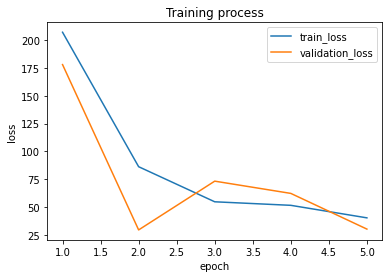

In [69]:
device = get_device()

clf = AudioClassifier()

clf.fit(train_loader, test_loader, epochs=5)